In [68]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import h5py
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms.functional import adjust_sharpness
import numba
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

In [69]:
section_path = '/mnt/WD6TB/tianaoli/brains/'
files = os.listdir(section_path)
print(len(files))

151


Prepare edge operators.

In [70]:
laplacian = torch.tensor([[[[-1, -1, -1],
                            [-1, 9, -1],
                            [-1, -1, -1]]]], dtype=torch.float32)
sobelx = torch.tensor([[[[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]]]], dtype=torch.float32)
sobely = torch.tensor([[[[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]]]], dtype=torch.float32)

Laplacian = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding='same', bias=False)
Laplacian.weight = nn.Parameter(laplacian, requires_grad=False)
Sobelx = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding='same', bias=False)
Sobelx.weight = nn.Parameter(sobelx, requires_grad=False)
Sobely = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding='same', bias=False)
Sobely.weight = nn.Parameter(sobely, requires_grad=False)

alpha, beta = 2, 7 # Weighting parameters for first and second order derivatives.

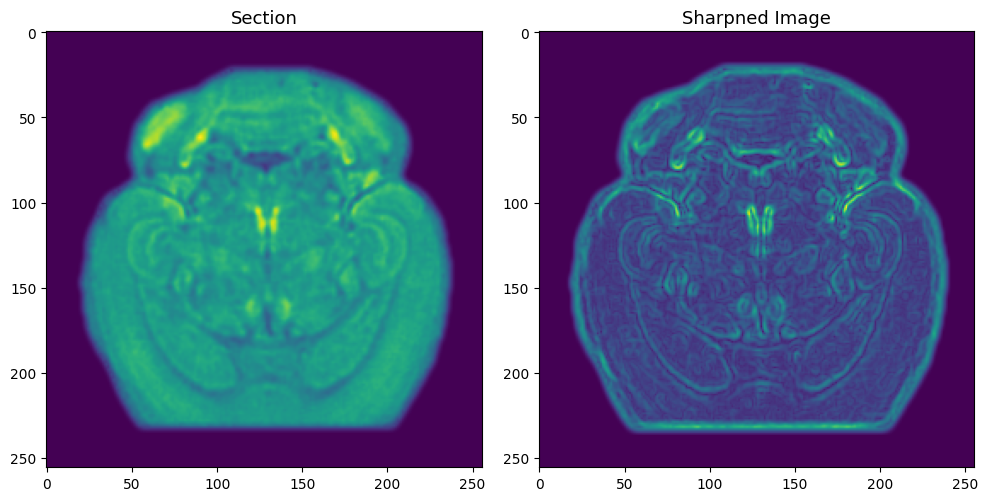

In [71]:
y_sec = 150
center_x, center_y = 127, 125
for idx, file in enumerate(files):
    if not idx == 0:
        continue
    data = scio.loadmat(os.path.join(section_path, file))
    brain3d = data['recondata_cut_mc_bgb']
   
    section = brain3d[:,y_sec,:]
    section = torch.tensor(section[center_x-85:center_x+86, center_y-85:center_y+86]).unsqueeze(0).unsqueeze(0)
    section = (section - section.min()) / (section.max() - section.min())
    section = F.interpolate(section, scale_factor=1.5, mode='bilinear')
    
    edge2 = Laplacian(section).abs().squeeze(0).squeeze(0)
    edge1x = Sobelx(section).squeeze(0).squeeze(0)
    edge1y = Sobely(section).squeeze(0).squeeze(0)
    edge1 = torch.sqrt(edge1x**2 + edge1y**2)
    section = section.squeeze(0).squeeze(0)
    section_sharp = section + edge2 * alpha + edge1 * beta
    
    # Visualization
    fig = plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)
    plt.imshow(section)
    plt.title('Section', fontsize=13)

    ax2 = plt.subplot(1,2,2)
    plt.imshow(section_sharp)
    plt.title('Sharpned Image', fontsize=13)
    plt.tight_layout()
    plt.savefig(f'/mnt/WD6TB/tianaoli/dataset/Brain/sections/vis/{idx}.jpg', bbox_inches='tight')
    
    # Save the images.
    for i in range(4):
        for j in range(4):
            np.save(f'/mnt/WD6TB/tianaoli/dataset/Brain/sections/{idx*16+4*i+j}.npy', section_sharp[64*i:64*(i+1),64*j:64*(j+1)])
